# Classifier code for training the datasets

## Generate Datasets

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import time
import sys
#df = pd.read_csv('/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/movementLeftFoot.csv')
#df=(df-df.std())/(df.mean())
path="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/New_feet/raw/"
if sys.platform.startswith('win'):
    path="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/robot/New_feet/raw/"
df = pd.read_csv(path+'carpet_d1.1_raw_L.csv')
#df=(df-df.std())/(df.mean())

print(df.keys())

torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print("GPU:",torch.cuda.is_available())


def genDataSet(var):
    X,y=sort_data("carpet_d1.1_raw_L.csv",var)
    X1,y1=sort_data("carpet_d1.1_raw_R.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("carpet_d1_raw_L.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("carpet_d1_raw_R.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("wood_d1_raw_R.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("wood_d1_raw_L.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    return X,y

def sort_data(name,vibration=True,dir="all"):
    df = pd.read_csv(path+name)
    df=pd.DataFrame(df).fillna(0)
    if vibration:
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z"]:
                ar.append(df[key])
        x=np.array(ar)
    else: #return without vibration data
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z","s_1_7","s_2_7"]:
                ar.append(df[key])
        x=np.array(ar)
    if dir=="left":
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z"] and "s_1" in key:
                ar.append(df[key])
        x=np.array(ar)
    elif dir=="right":
        ar=[]
        for key in list(df.keys()):
            if key not in ["x","y","z"] and "s_2" in key:
                ar.append(df[key])
        x=np.array(ar)
    x=x.T #transpose to have layers
    y=np.array([df['x'],df['y'],df['z']])
    y=y.T
    nan_indices = np.where(np.isnan(y))
    y[nan_indices]=0
    print("X data:",x.shape,"/ny data:",y.shape)
    return x,y

def getReductionMatrix(filename):
    x,y=sort_data(filename,vibration=True,dir="all") #loop through file name
    reduction = np.average(x,axis=0)
    return reduction

def gen_temporal_data(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,X.shape[1]*T))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.concatenate(ar,axis=0)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

def gen_temporal_data_2(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,T,X.shape[1]))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.array(ar)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y


def reduction_matrix(x_standard):
    return np.average(x_standard,axis=0)

X_,y_=gen_temporal_data(X,y,60)
print(X_.shape,y_.shape)


import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleNN, self).__init__()

        # Create a list to store the layers of the neural network
        layers = []

        # Add the input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.Sigmoid())  # You can use other activation functions as well
        #print(layers[0].weight.dtype)
        # Add the hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.Sigmoid())  # You can use other activation functions as well

        # Add the output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Define the forward pass of the network
        return self.model(x)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagation
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


Index(['time_step', 'x', 'y', 'z', 's_1_0', 's_1_1', 's_1_2', 's_1_3', 's_1_4',
       's_1_5', 's_1_6', 's_1_7', 's_1_8', 's_1_9', 's_1_10', 's_1_11',
       's_1_12', 's_1_13', 's_1_14', 's_1_15', 's_2_0', 's_2_1', 's_2_2',
       's_2_3', 's_2_4', 's_2_5', 's_2_6', 's_2_7', 's_2_8', 's_2_9', 's_2_10',
       's_2_11', 's_2_12', 's_2_13', 's_2_14', 's_2_15'],
      dtype='object')
11.7
GPU: True
(25590, 1920) (25590, 3)


## Classify texture

This section takes in a temporal window of tactile data and classifies which texture it is belonging to

In [3]:
var=1
X,y=sort_data("wood_d1_raw_R.csv",var)
X1,y1=sort_data("wood_d1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2.1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2.1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2.3_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

wood_X=X
wood_y=y.copy()

X1,yy=sort_data("carpet_d1.1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1.1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

carpet_x=X.copy()
carpet_y=y.copy()

X1,y1=sort_data("concrete_d2_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("concrete_d2_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("concrete_d2.1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("concrete_d2.1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

concrete_X=X.copy()
concrete_y=y.copy()

X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)


### Random forrest classifier

In [4]:


X=np.concatenate([concrete_X,carpet_x,wood_X])
y1=np.zeros((len(concrete_X),3))
y1[:,0]=1
y2=np.zeros((len(carpet_x),3))
y2[:,1]=1
y3=np.zeros((len(wood_X),3))
y3[:,2]=1
y=np.concatenate([y1,y2,y3])

X,y=gen_temporal_data(X,y,80)

X=(X-np.mean(X))/(np.std(X))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")

KeyboardInterrupt: 

### FNN

In [27]:

X_train=torch.tensor(X_train,dtype=torch.float32).to(device)
y_train=torch.tensor(y_train,dtype=torch.float32).to(device)

model = SimpleNN(len(X_train[0]), [1000,50], 3).to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs=10000

for epoch in range(num_epochs):
    total_loss = 0.0

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)

    # Calculate the loss
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = total_loss 
    if epoch%100==0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')


C:\Users\dexte\AppData\Local\Temp\ipykernel_23524\1130973042.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train=torch.tensor(X_train,dtype=torch.float32).to(device)
C:\Users\dexte\AppData\Local\Temp\ipykernel_23524\1130973042.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train=torch.tensor(y_train,dtype=torch.float32).to(device)


Epoch [1/10000], Loss: 1.2111
Epoch [101/10000], Loss: 1.0392
Epoch [201/10000], Loss: 1.0374
Epoch [301/10000], Loss: 1.0357
Epoch [401/10000], Loss: 1.0339
Epoch [501/10000], Loss: 1.0319
Epoch [601/10000], Loss: 1.0298
Epoch [701/10000], Loss: 1.0275
Epoch [801/10000], Loss: 1.0250
Epoch [901/10000], Loss: 1.0223
Epoch [1001/10000], Loss: 1.0193
Epoch [1101/10000], Loss: 1.0161
Epoch [1201/10000], Loss: 1.0126
Epoch [1301/10000], Loss: 1.0090
Epoch [1401/10000], Loss: 1.0051
Epoch [1501/10000], Loss: 1.0012
Epoch [1601/10000], Loss: 0.9972
Epoch [1701/10000], Loss: 0.9932
Epoch [1801/10000], Loss: 0.9891
Epoch [1901/10000], Loss: 0.9852
Epoch [2001/10000], Loss: 0.9813
Epoch [2101/10000], Loss: 0.9776
Epoch [2201/10000], Loss: 0.9740
Epoch [2301/10000], Loss: 0.9705
Epoch [2401/10000], Loss: 0.9672
Epoch [2501/10000], Loss: 0.9641
Epoch [2601/10000], Loss: 0.9612
Epoch [2701/10000], Loss: 0.9585
Epoch [2801/10000], Loss: 0.9560
Epoch [2901/10000], Loss: 0.9537
Epoch [3001/10000], Lo

In [49]:
X_test=torch.tensor(X_test,dtype=torch.float32).to(device)
y_test=torch.tensor(y_test,dtype=torch.float32).to(device)

predictions=model(X_test)
ind=torch.argmax(predictions,axis=1).cpu().detach().numpy()
pred=np.zeros_like(predictions.cpu().detach().numpy())
for i in range(len(pred)):
    pred[i][ind[i]]=1

accuracy = accuracy_score(y_test.cpu().detach().numpy(), pred)
print("Acc:",accuracy*100,"%")

C:\Users\dexte\AppData\Local\Temp\ipykernel_23524\3738214504.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test=torch.tensor(X_test,dtype=torch.float32).to(device)
C:\Users\dexte\AppData\Local\Temp\ipykernel_23524\3738214504.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test=torch.tensor(y_test,dtype=torch.float32).to(device)


Acc: 47.107637769900094 %


### Plotting the data

X data: (3600, 32) /ny data: (3600, 3)
pre reduction 10500.33312399356
post reduction 3519.8968753019303


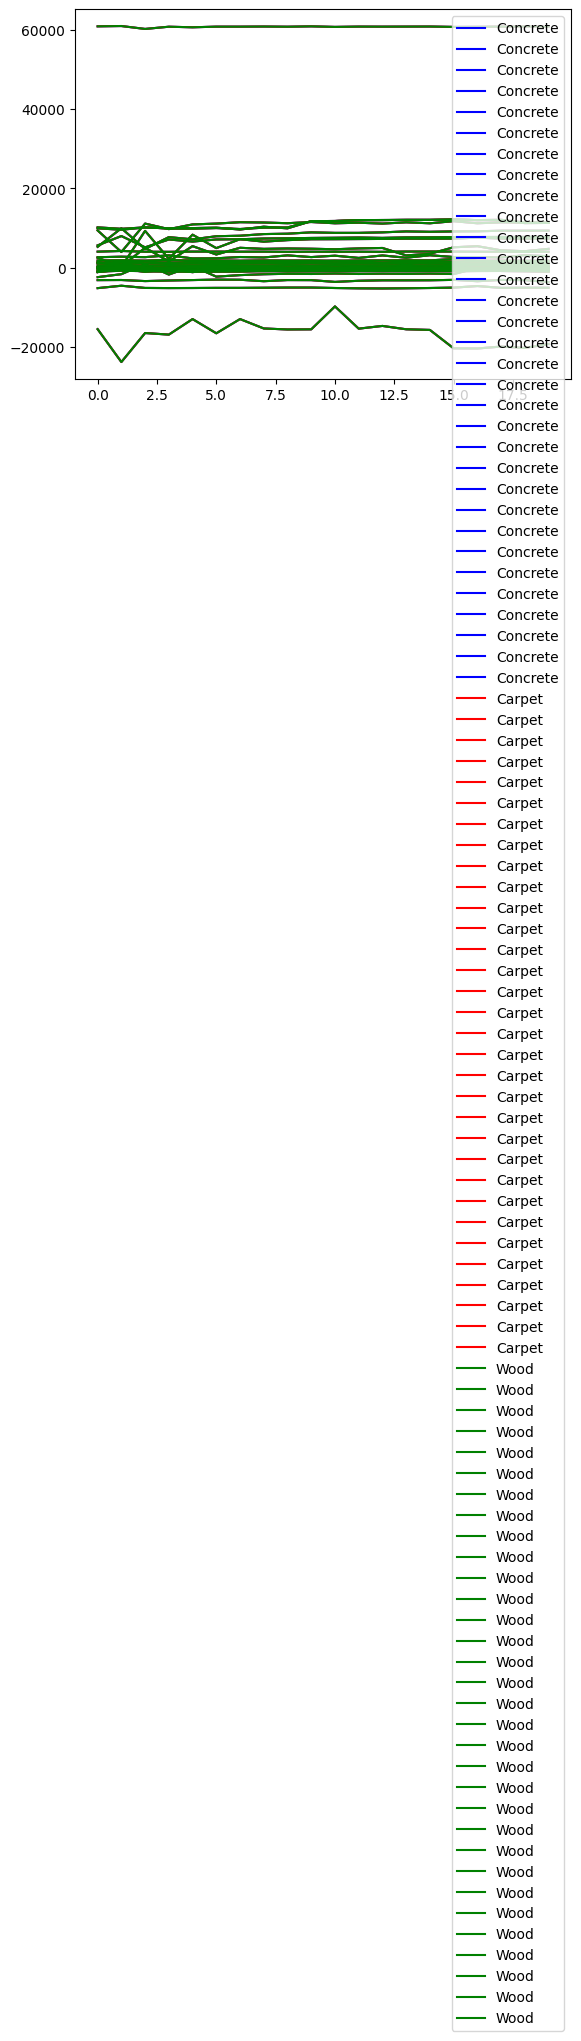

In [41]:
rd=getReductionMatrix("standing.csv")
X=np.concatenate([concrete_X,carpet_x,wood_X])
print("pre reduction",np.mean(X))
X=X-rd
X[X<0]=0
print("post reduction",np.mean(X))
y1=np.zeros((len(concrete_X),3))
y1[:,0]=1
y2=np.zeros((len(carpet_x),3))
y2[:,1]=1
y3=np.zeros((len(wood_X),3))
y3[:,2]=1
y=np.concatenate([y1,y2,y3])

X,y=gen_temporal_data_2(concrete_X-rd,y1,20)
plt.plot(X[0,0:20],c="b",label="Concrete")
X,y=gen_temporal_data_2(carpet_x-rd,y2,20)
plt.plot(X[0,0:20],c="r",label="Carpet")
X,y=gen_temporal_data_2(wood_X-rd,y3,20)
plt.plot(X[0,0:20],c="g",label="Wood")
plt.legend(loc="upper right")
plt.show()

### LSTM


In [42]:
def train(X_train,Y_train,X_test,Y_test,num_epochs = 100,learning_rate = 0.01):
    # Split your dataset into training and validation sets
    # train_data, val_data = ...
    lstm_model=LSTMModel(X_train.shape[2],64,2,Y_train.shape[1]).to(device)
    # Create data loaders for training and validation

    # Initialize the optimizer
    optimizer = optim.SGD(lstm_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    history_train=[]
    history_test=[]
    # Training loop
    for epoch in range(num_epochs):
        lstm_model.train()

        optimizer.zero_grad()
        # Forward pass
        outputs = lstm_model(X_train)

        # Calculate the loss
        loss = criterion(outputs, Y_train)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss = loss.item()
        history_train.append(total_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

        # Validation
        lstm_model.eval()
        with torch.no_grad():
            total_val_loss = 0

            outputs = lstm_model(X_test)
            val_loss = criterion(outputs, Y_test)
            total_val_loss = val_loss.item()

            print(f"Validation Loss: {total_val_loss:.4f}")
            history_test.append(total_val_loss)
    # Save the trained model
    #torch.save(lstm_model.state_dict(), "lstm_model.pth")
    predictions=lstm_model(X_test)
    ind=torch.argmax(predictions,axis=1).cpu().detach().numpy()
    pred=np.zeros_like(predictions.cpu().detach().numpy())
    for i in range(len(pred)):
        pred[i][ind[i]]=1
    accuracy = accuracy_score(y_test.cpu().detach().numpy(), pred)
    print("Acc:",accuracy*100,"%")
    return history_train, history_test, lstm_model

rd=getReductionMatrix("standing.csv")

X=np.concatenate([concrete_X,carpet_x,wood_X])-rd
X[X<0]=0
y1=np.zeros((len(concrete_X),3))
y1[:,0]=1
y2=np.zeros((len(carpet_x),3))
y2[:,1]=1
y3=np.zeros((len(wood_X),3))
y3[:,2]=1
y=np.concatenate([y1,y2,y3])

X,y=gen_temporal_data_2(X,y,20)

X=(X-np.mean(X))/(np.std(X))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train=torch.tensor(X_train,dtype=torch.float32).to(device)
y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
X_test=torch.tensor(X_test,dtype=torch.float32).to(device)
y_test=torch.tensor(y_test,dtype=torch.float32).to(device)

lossTrain,lossTest,model=train(X_train,y_train,X_test,y_test,num_epochs = 300,learning_rate = 0.01)

plt.plot(lossTrain)
plt.plot(lossTest)
plt.show()

X data: (3600, 32) /ny data: (3600, 3)


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.40 GiB (GPU 0; 16.00 GiB total capacity; 11.41 GiB already allocated; 0 bytes free; 24.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [19]:
preds=model(X_test)
ind=torch.argmax(preds,axis=1).cpu().detach().numpy()
preds=np.zeros_like(preds.cpu().detach().numpy())
for i in range(len(preds)):
    preds[i][ind[i]]=1
acc1=[0,1]
acc2=[0,1]
acc3=[0,1]
actual=y_test.cpu().detach().numpy()
for i in range(len(preds)):
    if list(actual[i])==[1,0,0]:
        if list(preds[i])==[1,0,0]:
            acc1[0]+=1
        acc1[1]+=1
    elif list(actual[i])==[0,1,0]:
        if list(preds[i])==[0,1,0]:
            acc1[0]+=1
        acc1[1]+=1
    elif list(actual[i])==[0,0,1]:
        if list(preds[i])==[0,0,1]:
            acc3[0]+=1
        acc3[1]+=1
print(acc1,acc2,acc3)
ac1=acc1[0]/acc1[1]
ac2=acc2[0]/acc2[1]
ac3=acc3[0]/acc3[1]

print("Accuracies of data sets: \n\n\tConcrete:",ac1,"\n\tCarpet:",ac2,"\n\tWood:",ac3)

[11784, 20050] [0, 1] [0, 4786]
Accuracies of data sets: 

	Concrete: 0.5877306733167083 
	Carpet: 0.0 
	Wood: 0.0


## Classify edges

This section we experiment with a regression model to classify simply where an edge is

In [98]:

filepath="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/edges/"
if sys.platform.startswith('win'): filepath="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/edges/"
x=np.load(filepath+"xdata1.npy")
y=np.load(filepath+"ydata1.npy")

x_lin=x.reshape((len(x),3*5))
x_noise=x_lin+np.random.normal(0,10,x_lin.shape)

x=np.concatenate([x_lin,x_noise])
y=np.concatenate([y,y])

x_train=x[0:int(len(x)*0.8)]
y_train=y[0:int(len(x)*0.8)]
x_test=x[int(len(x)*0.8):]
y_test=y[int(len(x)*0.8):]
print(x_lin.shape,y.shape)
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(x_train, y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(x_test)

Y_pred[Y_pred<0.5]=0
Y_pred[Y_pred>=0.5]=1
incorrect=np.sum(Y_pred-y_test)/len(Y_pred)
print("Accuracy test:",1-incorrect)

Y_pred = ridge_model.predict(x_train)

Y_pred[Y_pred<0.5]=0
Y_pred[Y_pred>=0.5]=1
incorrect=np.sum(Y_pred-y_train)/len(Y_pred)
print("Accuracy train:",1-incorrect)

(44, 15) (88, 4)
Accuracy test: 1.0
Accuracy train: 1.0


In [ ]:
#save model

#### Visualise

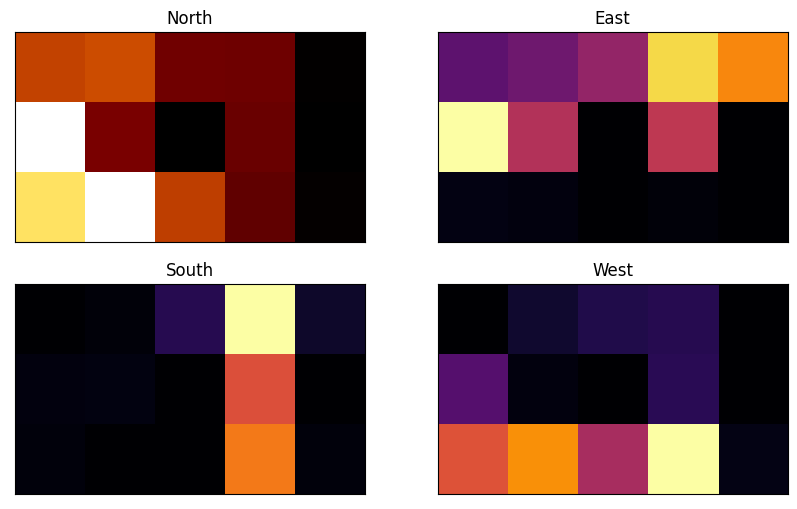

In [97]:
x=np.load(filepath+"xdata1.npy")
y=np.load(filepath+"ydata1.npy")

#mean_values = np.mean(x, axis=1, keepdims=True)
#std_dev_values = np.std(x, axis=1, keepdims=True)
#x = (x - mean_values) / std_dev_values

n=np.zeros_like(x[0])
s=np.zeros_like(x[0])
w=np.zeros_like(x[0])
e=np.zeros_like(x[0])
for i in range(len(x)):
    if list(y[i])==[1,1,0,0]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        n+=sig
    elif list(y[i])==[0,1,1,0]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        e+=sig
    elif list(y[i])==[0,0,1,1]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        s+=sig
    elif list(y[i])==[1,0,0,1]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        w+=sig

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0][0].imshow(n,cmap='inferno')
axs[0][0].set_title("North")
axs[0][0].xaxis.set_visible(False)
axs[0][0].yaxis.set_visible(False)

axs[0][1].imshow(e,cmap='inferno')
axs[0][1].set_title("East")
axs[0][1].xaxis.set_visible(False)
axs[0][1].yaxis.set_visible(False)

axs[1][0].imshow(s,cmap='inferno')
axs[1][0].set_title("South")
axs[1][0].xaxis.set_visible(False)
axs[1][0].yaxis.set_visible(False)

axs[1][1].imshow(w,cmap='inferno')
axs[1][1].set_title("West")
axs[1][1].xaxis.set_visible(False)
axs[1][1].yaxis.set_visible(False)

plt.show()

## Classify orientation

Continuing the previous work on classifying what the robots orientation is based off data   